# Learning Embeddings - IMDB Reviews

In [1]:
%load_ext autoreload
%autoreload 2

## Install `tfutils`

In [2]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Change to Project Directory

In [91]:
import os
os.chdir('/content/drive/MyDrive/projects/tensorflow-developer-certificate-deeplearning-ai/03-natural-language-processing-in-tensorFlow/course-notebooks/')
os.listdir('../')

['exercise-notebooks', 'course-notebooks', 'quizzes', 'README.md']

## Check GPU

In [2]:
!nvidia-smi

Sat Jul 24 07:48:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tfutils

In [110]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_SEQ_LEN = 100
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOKEN = '<oov>'
TEST_SIZE = 0.2
CLASS_NAMES = ['normal', 'sarcasm']

## Load Data

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-07-24 07:51:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.02s   

2021-07-24 07:51:19 (265 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [8]:
with open('/tmp/sarcasm.json', 'r') as f:
    datastore = json.load(f)

datastore[0].keys()

dict_keys(['article_link', 'headline', 'is_sarcastic'])

In [9]:
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])


## Train Test Split

In [116]:
from sklearn.model_selection import train_test_split

train_sents, test_sents, train_labels, test_labels = train_test_split(np.array(sentences), np.array(labels), test_size=TEST_SIZE)

print('train:', len(train_labels))
print('test:', len(test_labels))

train: 21367
test: 5342


In [33]:
train_labels[0:5]

[1, 1, 0, 0, 1]

## Tokenize

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(train_sents)

In [46]:
# Tokenize train_sents
train_token_ids = pad_sequences(tokenizer.texts_to_sequences(train_sents), maxlen=MAX_SEQ_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
test_token_ids = pad_sequences(tokenizer.texts_to_sequences(test_sents), maxlen=MAX_SEQ_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

## Analyze word counts

In [95]:
w2id = tokenizer.word_index
id2w = {v:k for k, v in w2id.items()}

In [24]:
wordcount_df = pd.DataFrame([tokenizer.word_counts]).T.rename(columns={0: 'count'}).sort_values('count', ascending=False)
wordcount_df.head()

,count
to,6578
of,4500
the,4136
in,3437
for,2673


In [28]:
print('Top 5 most common:', wordcount_df.iloc[:5].index.tolist())
print('Top 5 least common:', wordcount_df.iloc[-5:].index.tolist())

Top 5 most common: ['to', 'of', 'the', 'in', 'for']
Top 5 least common: ['welded', 'cajun', 'healers', "'zero", 'banal']


## Embedding layer

In [62]:
embed_layer = layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM, trainable=True)
embed_layer(train_token_ids[0:1])

<tf.Tensor: shape=(1, 100, 64), dtype=float32, numpy=
array([[[ 0.02943352, -0.03254768,  0.04232741, ...,  0.00935185,
         -0.03968676, -0.03812802],
        [ 0.01565223, -0.04318475,  0.01300324, ...,  0.02489419,
          0.04188237, -0.01167021],
        [ 0.02188902,  0.03128297,  0.04401943, ...,  0.00798762,
          0.01061379, -0.04171606],
        ...,
        [ 0.03316057,  0.04738809,  0.03552736, ..., -0.012644  ,
          0.02002596, -0.0353973 ],
        [ 0.03316057,  0.04738809,  0.03552736, ..., -0.012644  ,
          0.02002596, -0.0353973 ],
        [ 0.03316057,  0.04738809,  0.03552736, ..., -0.012644  ,
          0.02002596, -0.0353973 ]]], dtype=float32)>

* Output embeddings are for all 100 tokens of 16 dimension each

## Simple model to learn embeddings

In [83]:
model = tf.keras.models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM,
                     trainable=True, input_length=MAX_SEQ_LEN),
    layers.GlobalAveragePooling1D(), # Averaging the embeddings of each token to obtain the sentence embedding
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')             
])

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 16)           160016    
_________________________________________________________________
global_average_pooling1d_15  (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 160,593
Trainable params: 160,593
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model.fit(train_token_ids, train_labels, validation_split=0.1, epochs=30, batch_size=32, verbose=2)

Epoch 1/30
601/601 - 3s - loss: 0.6884 - accuracy: 0.5598 - val_loss: 0.6836 - val_accuracy: 0.5746
Epoch 2/30
601/601 - 2s - loss: 0.6855 - accuracy: 0.5622 - val_loss: 0.6824 - val_accuracy: 0.5746
Epoch 3/30
601/601 - 2s - loss: 0.6853 - accuracy: 0.5622 - val_loss: 0.6823 - val_accuracy: 0.5746
Epoch 4/30
601/601 - 2s - loss: 0.6853 - accuracy: 0.5622 - val_loss: 0.6822 - val_accuracy: 0.5746
Epoch 5/30
601/601 - 2s - loss: 0.6852 - accuracy: 0.5622 - val_loss: 0.6821 - val_accuracy: 0.5746
Epoch 6/30
601/601 - 2s - loss: 0.6851 - accuracy: 0.5622 - val_loss: 0.6822 - val_accuracy: 0.5746
Epoch 7/30
601/601 - 2s - loss: 0.6851 - accuracy: 0.5622 - val_loss: 0.6823 - val_accuracy: 0.5746
Epoch 8/30
601/601 - 2s - loss: 0.6850 - accuracy: 0.5622 - val_loss: 0.6824 - val_accuracy: 0.5746
Epoch 9/30
601/601 - 2s - loss: 0.6849 - accuracy: 0.5622 - val_loss: 0.6823 - val_accuracy: 0.5746
Epoch 10/30
601/601 - 2s - loss: 0.6848 - accuracy: 0.5622 - val_loss: 0.6824 - val_accuracy: 0.5746

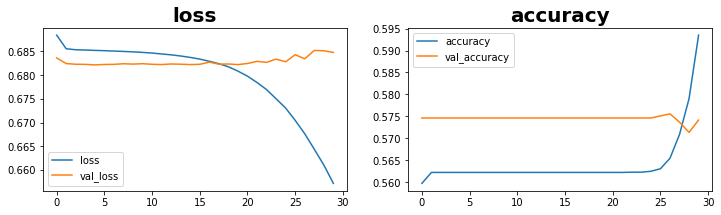

In [85]:
from tfutils.visualize import plot_learning_curve

plot_learning_curve(history, extra_metric='accuracy');

## Get the learned embedding

In [87]:
embedding_weights = model.layers[0].get_weights()[0]
print(embedding_weights.shape)

(10001, 16)


In [92]:
!mkdir ../output

array([[ 0.0171933 ,  0.04335922, -0.05359538, ..., -0.02603859,
         0.02612437,  0.0425262 ],
       [-0.14279091, -0.0043941 ,  0.1266315 , ...,  0.07891649,
        -0.10182814, -0.03558915],
       [ 0.0069366 , -0.01270428, -0.04130226, ..., -0.01777848,
         0.03917974, -0.04579635],
       ...,
       [ 0.08978668, -0.0454936 , -0.07385948, ..., -0.13290448,
         0.05379527, -0.08891229],
       [ 0.09268588, -0.01638403, -0.01835665, ..., -0.04653244,
         0.07908419, -0.08582627],
       [ 0.0133255 ,  0.01291717, -0.03713045, ..., -0.00085948,
         0.0256307 ,  0.02821362]], dtype=float32)

In [99]:
'\t'.join(embedding_weights[1].astype(str))

'-0.14279091\t-0.0043941033\t0.1266315\t0.11743535\t0.069566436\t-0.08150205\t-0.05059182\t0.061411887\t0.08587597\t0.092220485\t-0.11831636\t0.02717597\t0.044681076\t0.07891649\t-0.101828136\t-0.035589147'

In [104]:
import io

with io.open('../output/sarcasm_embed_weights_nb2.tsv', 'w', encoding='utf-8') as f:
    for idx in range(1, embedding_weights.shape[0]):
        word = id2w[idx]
        vec = embedding_weights[idx]
        f.write(word + '\t' + '\t'.join(embedding_weights[1].astype(str)) + '\n')

In [105]:
!head -n 5 ../output/sarcasm_embed_weights_nb2.tsv

<oov>	-0.14279091	-0.0043941033	0.1266315	0.11743535	0.069566436	-0.08150205	-0.05059182	0.061411887	0.08587597	0.092220485	-0.11831636	0.02717597	0.044681076	0.07891649	-0.101828136	-0.035589147
to	-0.14279091	-0.0043941033	0.1266315	0.11743535	0.069566436	-0.08150205	-0.05059182	0.061411887	0.08587597	0.092220485	-0.11831636	0.02717597	0.044681076	0.07891649	-0.101828136	-0.035589147
of	-0.14279091	-0.0043941033	0.1266315	0.11743535	0.069566436	-0.08150205	-0.05059182	0.061411887	0.08587597	0.092220485	-0.11831636	0.02717597	0.044681076	0.07891649	-0.101828136	-0.035589147
the	-0.14279091	-0.0043941033	0.1266315	0.11743535	0.069566436	-0.08150205	-0.05059182	0.061411887	0.08587597	0.092220485	-0.11831636	0.02717597	0.044681076	0.07891649	-0.101828136	-0.035589147
in	-0.14279091	-0.0043941033	0.1266315	0.11743535	0.069566436	-0.08150205	-0.05059182	0.061411887	0.08587597	0.092220485	-0.11831636	0.02717597	0.044681076	0.07891649	-0.101828136	-0.035589147


## Test on a sentence

In [125]:
sents_new = ['deep learning is a bunch of middle school stuff', 'I actually love this shirt']

sents_new_token_ids = pad_sequences(tokenizer.texts_to_sequences(sents_new), maxlen=MAX_SEQ_LEN, 
                                    padding=PADDING_TYPE, truncating=TRUNC_TYPE)

pred_probs = model.predict(sents_new_token_ids)
pred_labs = np.squeeze((pred_probs > 0.5).astype(int))
pred_clsnames = np.array(CLASS_NAMES)[pred_labs]
print(pred_clsnames)

['normal' 'normal']
